A notebook to load spike times from raw data and attribute it to each blurred image presentation.\
The output are two npz files containing array that have the dimension Ncells x Nimg x Npup x Ndf x Nsrc and contain:
- firing rates
- the rasters for each image (25 presentations)

In [1]:
rootF = 'D:/Data/Paper defocus/MEA/'

In [2]:
import os as os
import sys

from numpy import *
import pandas as pd

from matplotlib.pyplot import *
import matplotlib.image as mpimg

from shared.extract_triggers import *
from shared.save_load import *

# Load measurements times 

In [82]:
exp = 20211129

Exp 20211129
0 218211
1 32400
2 272800
3 110984
4 32400
0 sec
3647.1 sec
4346.6 sec
11416.900000000001 sec
15127.600000000002 sec
15829.500000000002 sec


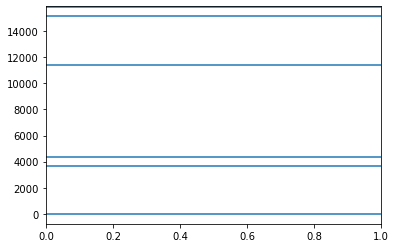

In [83]:
Mtimes = []
Trigs = []

fs=20000 # freq acquisition

print ('Exp', exp)

if exp == 20211207:
    nmeas=6
elif exp in [20211129, 20211208, 20221213, 20221214, 20230105]:
    nmeas = 5
    
time_elapsed = 0

measAll= arange(10)+1

for measnum in arange(nmeas):
    meas=measAll[measnum]
    
    trig_path = rootF + '/exp' + str(exp) + '/triggers/'
    
    trigs,ttot= load_obj(trig_path + 'exp'+str(exp)+'-meas_0' + str(meas) + '_triggers_unfilt')
    
    print (measnum, len(trigs))
    
    Trigs.append(time_elapsed+trigs/fs)
    Mtimes.append(time_elapsed)
    
    time_elapsed+=ttot
Mtimes.append(time_elapsed)

for m in Mtimes[:]: # time in seconds
    axhline(m)
    print(m, 'sec')

# Load spike data

In [84]:
rootData = rootF + '/exp' + str(exp) + '/sorting/'

spike_times= load(rootData + 'spike_times.npy')
spike_clusters= load(rootData + 'spike_clusters.npy')  

try:
    import csv as csv
    cgf = open(rootData + 'cluster_group.tsv')  
    cgfr = csv.reader(cgf,delimiter="\t") 
    cluster_group = dict()
    next(cgfr)
    for row in cgfr:
        cluster_group[row[0]]=row[1]
    Clusters = array(list(cluster_group.keys()),dtype='int')
except:
    1

print ('Total number of clusters:', len(Clusters))

Total number of clusters: 339


## Select the good cells

### Cells selected based on their ID cards

In [85]:
results_path = rootF +  '/exp' + str(exp) + '/'
    
cluster_selection = pd.read_excel(results_path + str(exp) + '_cluster_selection.xlsx', header=0)

good_cells = cluster_selection['Cluster']

print (len(good_cells), 'good cells!')

116 good cells!


# Make and save rasters

In [86]:
if exp in [20211207, 20221213, 20221214, 20230105]:
    meas=4
    print ('Exp', exp, 'measurement', meas)
elif exp in[ 20211129, 20211208]:
    meas=3
    print ('Exp', exp, 'measurement', meas)
else:
    print ('problem!')
    
#-----------------------------------------------
# Experiment conditions organization

Imgs = ['1','2','3','5']
pupDiams = ['1.40','2.00']
sources = ['1','2','3','4']
dFs = ['+40','+30','+20','+10','+00','-10','-20','-30','-40']
    
Nimgs = len(Imgs)
NpupDiams = len(pupDiams)
Nsources = len(sources)
NdFs = len(dFs)

Nreps = 25

stim_index = meas-1 # in Trigs
date = '20210512-' 

#-----------------------------------------------    
import csv as csv
#-----------------
# Get start times to make rasters
#-----------
# Get stim trials

if exp in [20211129, 20211207, 20211208, 20220204, 20220224, 20220707, 20220712, 20221201, 20221213, 20221214, 20230105]:
    if xps:
        stimF = 'F:/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi_merge/'
    else:
        # stimF = '/media/sarah/Sarah_1/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi_merge/'
        stimF = '/mnt/ad978934-bc32-4a32-abbf-287b415f9e41/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi_merge/'
        
stim_trials_f= open(stimF + 'fi_merge_fipwfc_trials.csv') # file that contains the condition number, the start and end of the display
stim_trials_f = csv.reader(stim_trials_f,delimiter=",")

stim_trials=[]
for row in stim_trials_f:
    stim_trials.append(np.array(row))

stim_trials_head = stim_trials[0]
stim_trials = np.array(stim_trials[1:]).astype(double)
print(stim_trials_head)
print (len(stim_trials))

#-------------------------------
#convert to times with trigtimes
trigs = Trigs[stim_index]

for st in stim_trials:
    st[2]=trigs[int(st[2])]#+160]
    st[3]=trigs[int(st[3])+1]

#-----------
#======================================
def get_image_data(im_name):
    
    for i in Imgs:
        if 'image_'+i in im_name: break
            
    for p in pupDiams:
        if 'pupDiam='+p in im_name: break
    
    for s in sources:
        if 'Source_'+s in im_name: break
        
    for d in dFs:
        if 'dF='+d in im_name: break
            
    return Imgs.index(i),pupDiams.index(p),sources.index(s),dFs.index(d)
#======================================
#---------------------
# Get images start times

if exp in [20211129, 20211207, 20211208, 20220204, 20220224, 20220712, 20220707, 20221201, 20221213, 20221214, 20230105]:
    if xps:
        im_list =  load_obj('F:/MEA data/stimulations/fipwfc_20211123_convolved_288elements/datasets/convolved_image_list')
    else:
        im_list =  load_obj('/mnt/ad978934-bc32-4a32-abbf-287b415f9e41/MEA data/stimulations/fipwfc_20211123_convolved_288elements/datasets/convolved_image_list')
        
        
im_starts= zeros([Nimgs,NpupDiams,Nsources,NdFs,Nreps])
im_count = zeros([Nimgs,NpupDiams,Nsources,NdFs],dtype='int')

for stim in stim_trials:
    condition = int(stim[1])
    im_code =  condition+1       # Image number code is condition +1   (Ex. condition 0 is image1)
    
    im_name = im_list[im_code][0]
    im_nb,pup_nb,source_nb,dF_nb = get_image_data(im_name)
        
    im_starts[im_nb,pup_nb,source_nb,dF_nb,im_count[im_nb,pup_nb,source_nb,dF_nb]] = stim[2] # an array that contains the start time for each stimulation
    im_count[im_nb,pup_nb,source_nb,dF_nb]+=1 


Exp 20211129 measurement 3
['' 'condition_nb' 'start_display_nb' 'end_display_nb']
7200


## Computing rasters and firing rates

During image presentation and next grey frame

In [87]:
raster_len = 0.6 # seconds 
bin_size = 0.05
n_bins = round(raster_len/bin_size)

spike_data = empty([len(good_cells), Nimgs, NpupDiams, NdFs, Nsources, n_bins]) # firing rates 

rasters = []

for i in range(len(good_cells)):
    
    clus=good_cells[i] 
    print('cluster ', clus)
    
    #Get spike_times
    sp_times = spike_times[spike_clusters==int(clus)]/fs
    print('Nspikes: ',len(sp_times))
    
    #Get spikes during the stimulation
    stim_sptimes = sp_times[(sp_times>Mtimes[stim_index]) & (sp_times<Mtimes[stim_index+1])]
    print('sptimes in stim: ',len(stim_sptimes), '   % spikes: ' ,round(len(stim_sptimes)/len(sp_times)*100,1))
    
    cell_rasters = []
    # Get start times and make rasters
    for img in range(Nimgs): #the number of images
        img_rasters = []
        for pup in range(NpupDiams):
            pup_rasters = []
            for dF in range(NdFs):
                dF_rasters = []
                for source in range(Nsources):

                    binned_spikes = np.empty((Nreps, n_bins)) 
                    raster = []
                    all_spikes = []
                    for k,st_time in enumerate(im_starts[img,pup,source,dF]): # 25 times the same repetition for each condition

                        #For each presentation of the condition (st_time), 
                        #we select the corresponding spikes (from stim_sptimes) in a time range of 600 ms
                        ev_spikes=stim_sptimes[(stim_sptimes>=st_time) & (stim_sptimes<st_time+raster_len)]
                        rast_times=ev_spikes-st_time
    
                        #Raster
                        raster.append(rast_times)

                        for j in range(len(rast_times)):
                            all_spikes.append(rast_times[j])
                    
                    all_spikes_hist = histogram(all_spikes, bins=n_bins)[0]
                    
                    # Transform spike count in firing rate (accross time)
                    firing_rate = all_spikes_hist/25 * (1./bin_size) # 25 repetitions
                    # Save
                    spike_data[i,img,pup,dF,source,:] = firing_rate
                    
                    dF_rasters.append(raster)
                pup_rasters.append(dF_rasters)
            img_rasters.append(pup_rasters)
        cell_rasters.append(img_rasters)
    rasters.append(cell_rasters)  

rasters = array(rasters, dtype='object')
shape(rasters)

cluster  1
Nspikes:  214638
sptimes in stim:  118710    % spikes:  55.3
cluster  22
Nspikes:  43953
sptimes in stim:  20830    % spikes:  47.4
cluster  25
Nspikes:  24707
sptimes in stim:  11132    % spikes:  45.1
cluster  27
Nspikes:  41894
sptimes in stim:  20486    % spikes:  48.9
cluster  42
Nspikes:  262890
sptimes in stim:  110804    % spikes:  42.1
cluster  43
Nspikes:  87197
sptimes in stim:  48499    % spikes:  55.6
cluster  44
Nspikes:  86265
sptimes in stim:  52199    % spikes:  60.5
cluster  45
Nspikes:  73237
sptimes in stim:  29341    % spikes:  40.1
cluster  50
Nspikes:  277968
sptimes in stim:  115820    % spikes:  41.7
cluster  69
Nspikes:  370919
sptimes in stim:  166531    % spikes:  44.9
cluster  76
Nspikes:  29910
sptimes in stim:  11239    % spikes:  37.6
cluster  77
Nspikes:  200751
sptimes in stim:  88567    % spikes:  44.1
cluster  79
Nspikes:  29696
sptimes in stim:  12006    % spikes:  40.4
cluster  80
Nspikes:  21256
sptimes in stim:  10247    % spikes:  48.

(116, 4, 2, 9, 4, 25)

### Plots for sanity check

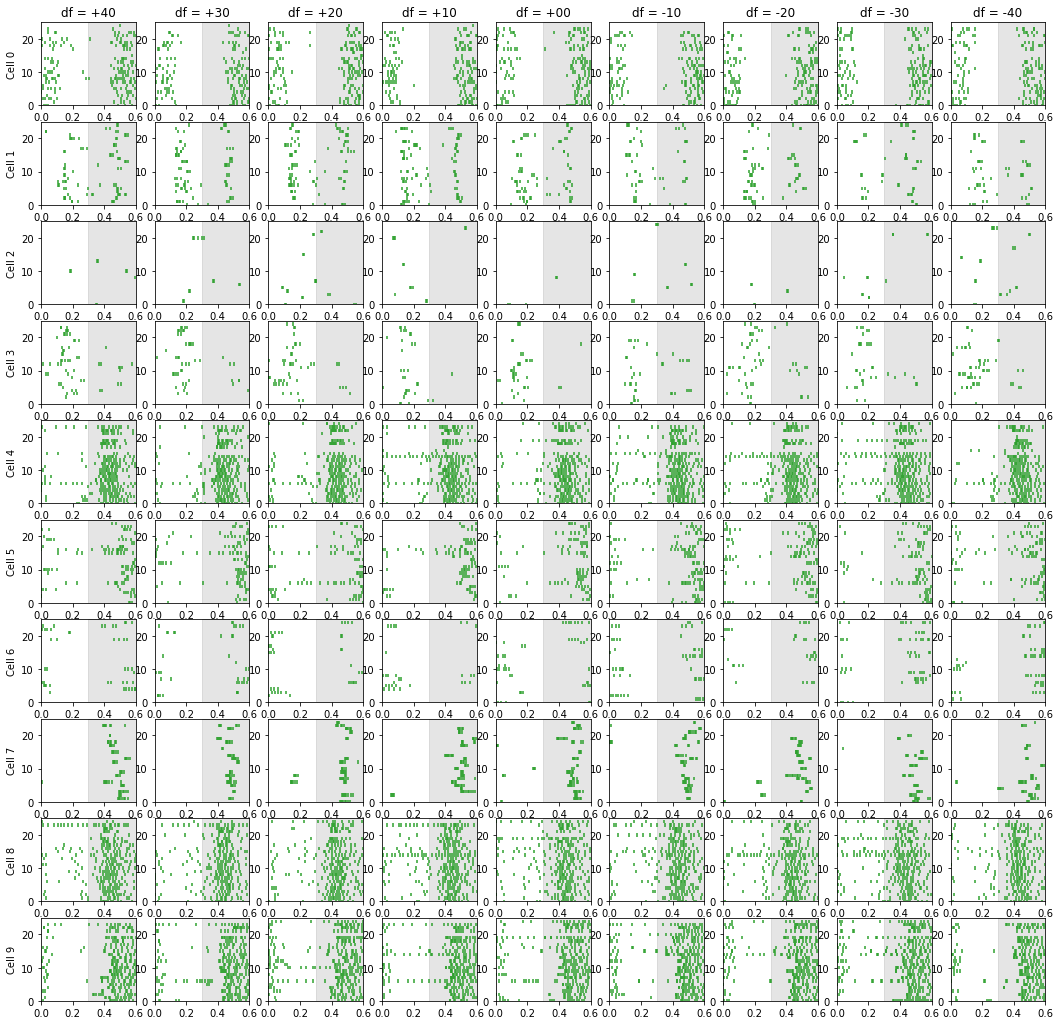

In [88]:
cols = ['C0','C1','C2','C3']

iImg = 2
iEcc = 0
iPup = 0

fig = figure(figsize=(18,18))

gs = fig.add_gridspec(10, 9)

for iCell in range(0, 10):
    for iDf in range(NdFs):
        ax = fig.add_subplot(gs[iCell,iDf])
        ax.eventplot(rasters[iCell,iImg,iPup,iDf,iEcc], color=cols[iImg])
        ax.axvspan(0.3, 0.6, color='k', alpha=0.1)
        ax.set_ylim(0,Nreps)
        ax.set_xlim(0,raster_len)
        if iCell == 0:
            ax.set_title('df = {}'.format(dFs[iDf]))
        if iDf == 0:
            ax.set_ylabel('Cell {}'.format(iCell))

In [111]:
# Saving firing rates and rasters

output_folder = rootF + '/exp' + str(exp) + '/'
    
savez(output_folder + str(exp) + '_cells_firing_rates.npz', clusters = good_cells, firing_rates = spike_data)
savez(output_folder + str(exp) + '_cells_rasters.npz', clusters = good_cells, rasters = rasters)